#### **Methods below includes**:

1. Pair-wise correlation inside a brain area
2. decay plot of a brain area, correlation decay through time.    

**Be aware that pix num of each brain area might affect this in value.**

___
Load in data

In [ ]:
# import and basic path part
import Common_Functions as cf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import pandas as pd
# from Atlas_Corr_Tools import Atlas_Data_Tools,Contra_Similar
from Brain_Atlas.Atlas_Mask import Mask_Generator
import copy

wp=r'D:\_DataTemp\OIS\Wild_Type\Preprocessed'
series = np.load(cf.join(wp,'z_series.npy'))

# join chamber mask with brain area mask, getting only mask with values.
mask = cv2.imread(cf.join(wp,'Chamber_mask.png'),0)>0
joint_mask = (series.std(0)>0)*mask*mask[:,::-1]

series = np.clip(series,-3,3)*joint_mask


___
- ##### Part 1, pair-wise correlation inside a brain area.    
We combine 6 area, Left&Right Visual,Somatosensory,Motion area, getting it's pairwise correlation.

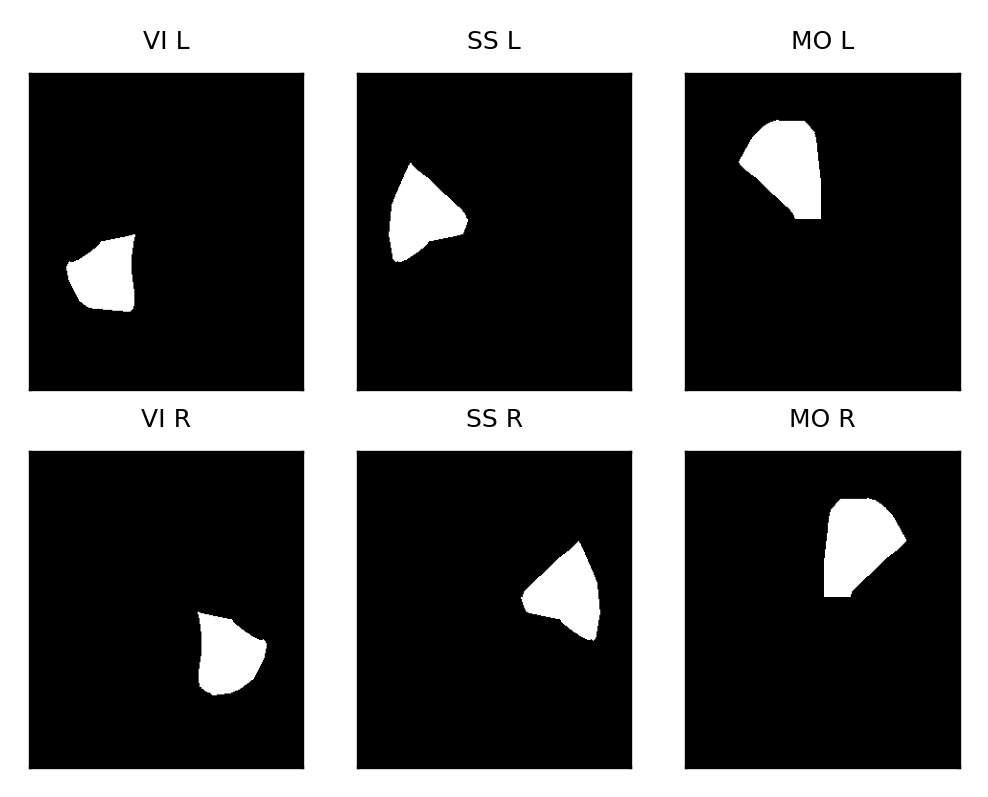

In [23]:
MG = Mask_Generator(bin=4)

masks = []
funcs = ['VI','VI','SS','SS','MO','MO']
hemi = ['L','R','L','R','L','R']
for i,c_func in enumerate(funcs):
    c_mask = joint_mask*MG.Get_Func_Mask(c_func,hemi[i])
    masks.append(c_mask)

fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(4,3),dpi=300)
for i in range(6):
    ax[i%2,i//2].imshow(masks[i],cmap='gray')
    ax[i%2,i//2].set_yticks([])
    ax[i%2,i//2].set_xticks([])
    ax[i%2,i//2].set_title(f'{funcs[i]} {hemi[i]}',size=6)
    



- After mask generation, do 6 pair-wise correlation inside each area.    
We have already packed up function, use this can get paiwise-corr matrix.    

This calculation is costy, and pair corr matrix a little big.

In [28]:
from Atlas_Corr_Tools import Paiwise_Calculator,Pairwise_ID_Loc

for i in range(6):
    c_corr = Paiwise_Calculator(matrix=series,mask=masks[i])
    c_corr['Area'] = funcs[i]
    c_corr['Hemi'] = hemi[i]
    if i == 0:
        pair_corr = copy.deepcopy(c_corr)
    else:
        pair_corr = pd.concat([pair_corr,c_corr])

print(f' Total {len(pair_corr)} pairs compared')
cf.Save_Variable(wp,'All_Pair_Corr',pair_corr)

 Total 80131531 pairs compared


True

Let's show the structure of this variable.

In [36]:
print(pair_corr.iloc[2])
# this will return each pair's ID-A,ID-B,distance(euler),pearson's r, func area, hemispher.

ID_A                  1
ID_B                  4
Distance       4.123106
Correlation    0.990798
Area                 VI
Hemi                  L
Name: 2, dtype: object


In [35]:
# Use this function will get the ID's Y,X coordinate in real space. 
Pairwise_ID_Loc(masks[0],5)

(np.int64(169), np.int64(104))

___
##### Part 2, decay plot of brain area.
- First we see the decay by distance of a single area.

<Axes: xlabel='Distance', ylabel='Correlation'>

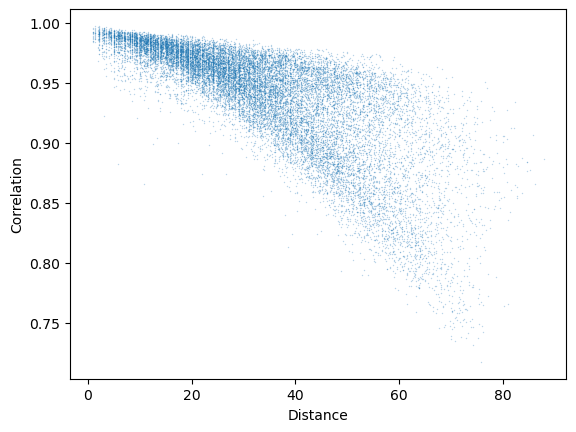

In [42]:
LV = pair_corr.groupby(['Hemi','Area']).get_group(('L','VI'))
example = LV.sample(20000,axis=0)
sns.scatterplot(data =example,x='Distance',y='Correlation',s=1,lw=0,alpha=0.3)

That's easy , so let's see whether we can show all 6 conditions in a single graph.    
- Note that there are tens of millions points, so you need to sample before visualization.

In [49]:
sampled_pair_corr = (
    pair_corr.groupby(['Hemi', 'Area'], group_keys=False).
    apply(lambda x: x.sample(n=20000, replace=True if len(x) < 20000 else False)).
    reset_index(drop=True)
)
sampled_pair_corr.shape

C:\Users\rui_z\AppData\Local\Temp\ipykernel_62844\501381721.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply(lambda x: x.sample(n=20000, replace=True if len(x) < 20000 else False)).


(120000, 6)

(0.7, 1.0)

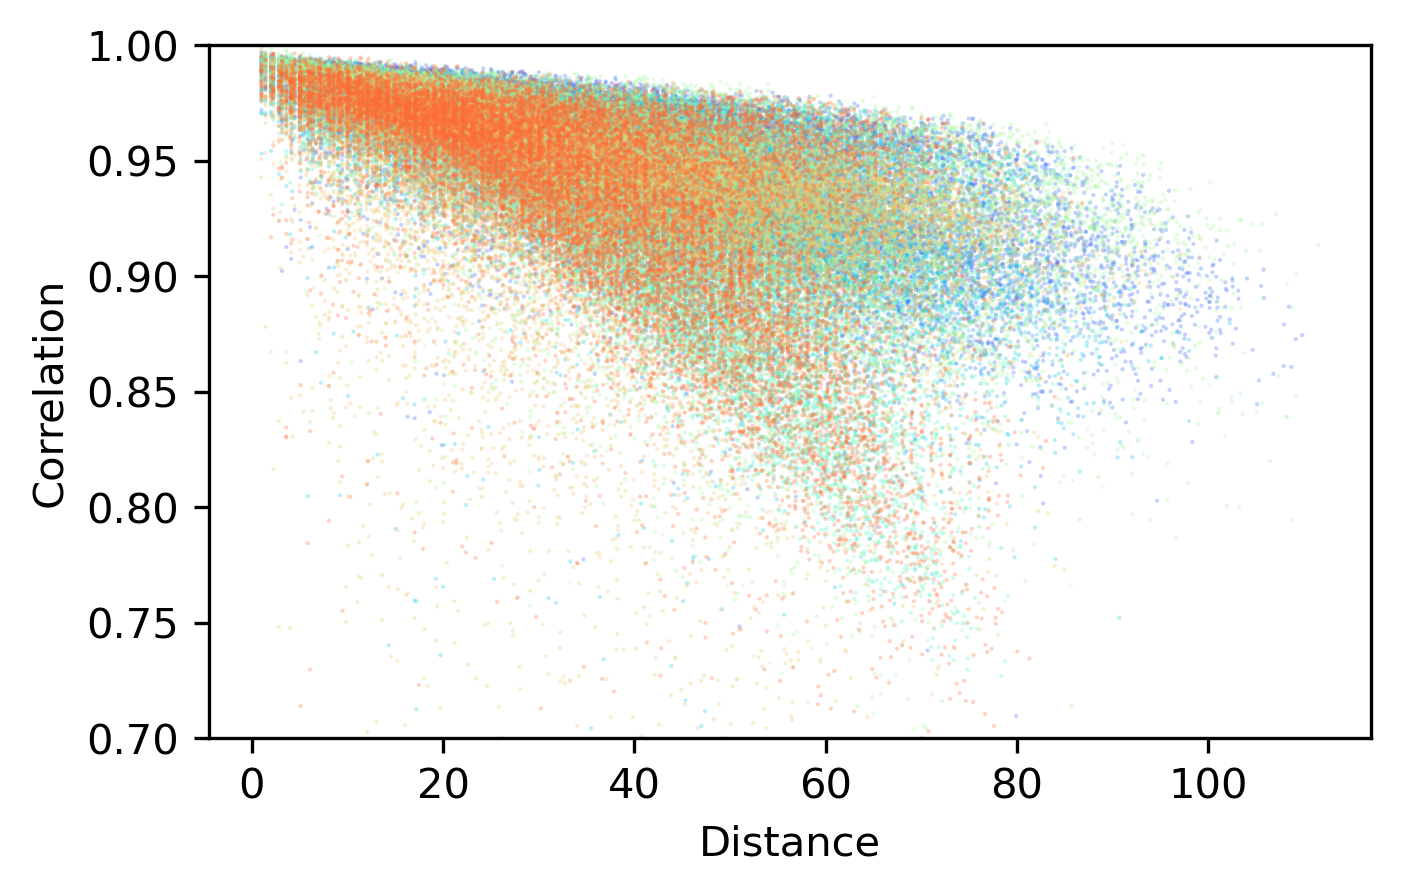

In [66]:
# then plot sampled scatter map on graph.
sampled_pair_corr['group']=sampled_pair_corr['Area']+'_'+sampled_pair_corr['Hemi']

fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (5,3),dpi = 300)
sns.scatterplot(data = sampled_pair_corr,hue='group',x='Distance',y='Correlation',s=1,lw=0,alpha=0.3,palette='rainbow',legend=False,ax = ax)
ax.set_ylim(0.7,1)


- Now we can fit 6 codition's data into 6 curves, and plot it.

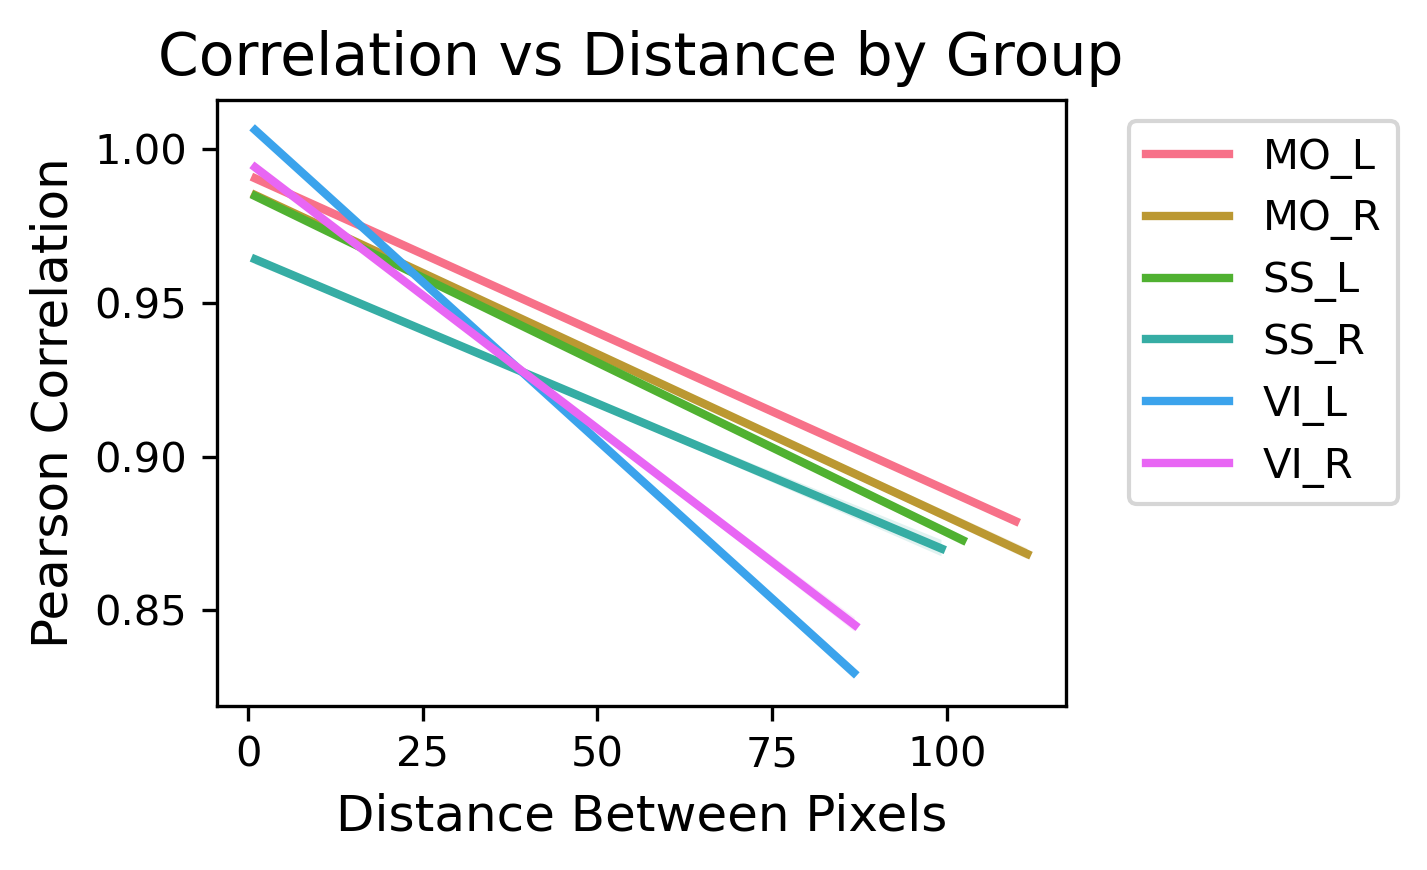

In [67]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (5,3),dpi = 300)
palette = sns.color_palette("husl", n_colors=6)  # 6 distinct colors

# 4. Plot regression lines with confidence intervals
for (group_name, group_data), color in zip(sampled_pair_corr.groupby('group'), palette):
    sns.regplot(
        x='Distance',
        y='Correlation',
        data=group_data,
        scatter=False,  # Hide individual points
        ci=95,  # 95% confidence interval
        line_kws={'lw': 2, 'color': color},
        label=group_name,
        ax=ax
    )

# 5. Customize plot
ax.set_title('Correlation vs Distance by Group', fontsize=14)
ax.set_xlabel('Distance Between Pixels', fontsize=12)
ax.set_ylabel('Pearson Correlation', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside
plt.tight_layout()
plt.show()

👆 Visual cortex seems to decay faster than other cortex. If you want to prove it, more case is necessary.    

Below will show the method to get R2 and slope of all 6 cases.    
As regression will not visualize directly, we can use all data for calculation.

In [74]:
from scipy import stats

def compute_regression(df):
    results = []
    for (hemi, func), group in df.groupby(['Hemi', 'Area']):
        x = group['Distance'].values
        y = group['Correlation'].values
        
        # Compute regression using SciPy
        slope, intercept, r_value, p_value, stderr = stats.linregress(x, y)
        n = len(x)
        df_degrees = n - 2  # Degrees of freedom
        
        # Compute 95% confidence interval for slope
        t_crit = stats.t.ppf(0.975, df_degrees)
        slope_ci_low = slope - t_crit * stderr
        slope_ci_high = slope + t_crit * stderr
        
        # Calculate MSE and R²
        y_pred = intercept + slope * x
        residuals = y - y_pred
        mse = np.sum(residuals**2) / df_degrees
        r_squared = r_value**2
        
        results.append({
            'Hemi': hemi,
            'funcs': func,
            'Slope': slope,
            'Slope_CI_Low': slope_ci_low,
            'Slope_CI_High': slope_ci_high,
            'Intercept': intercept,
            'R_squared': r_squared,
            'MSE': mse,
            'n': n,
            'p':p_value
        })
    
    return pd.DataFrame(results)

# Get regression results
results_df = compute_regression(pair_corr)

Text(0, 0.5, 'Slopes *e-3')

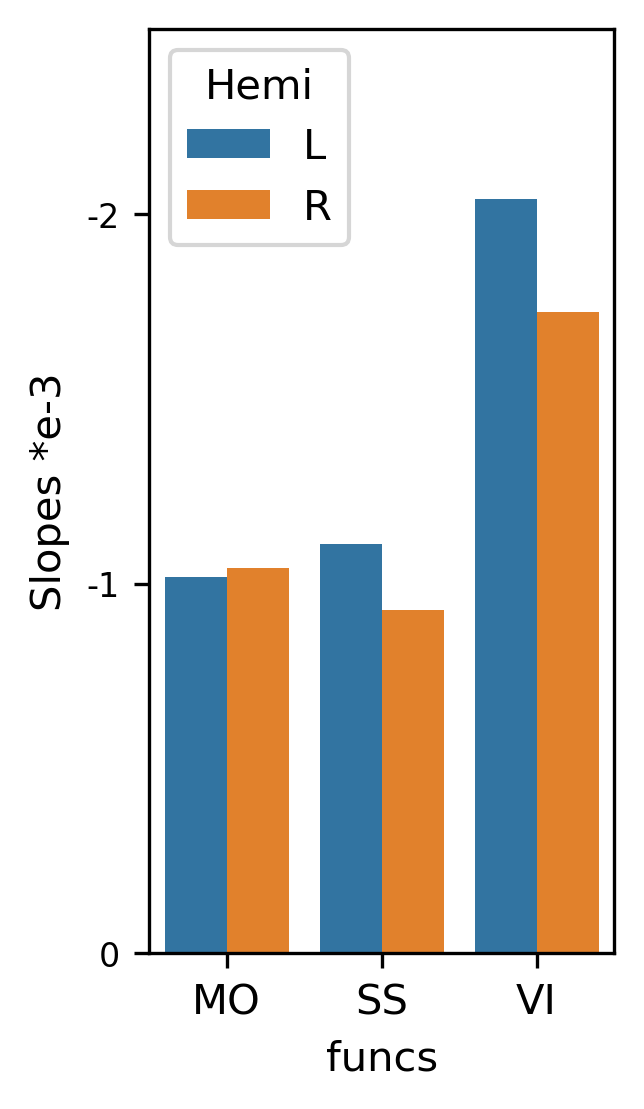

In [82]:
fig,ax = plt.subplots(ncols=1,nrows=1,dpi=300,figsize=(2,4))
sns.barplot(data=results_df,y='Slope',x='funcs',hue='Hemi',ax=ax)
ax.set_ylim(0,-0.0025)
ax.set_yticks([0,-0.001,-0.002])
ax.set_yticklabels([0,-1,-2],size=8)
ax.set_ylabel('Slopes *e-3')
